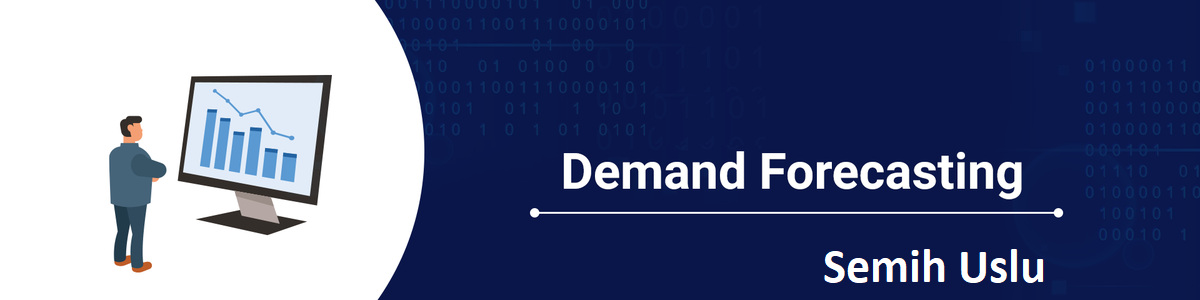

<h1 class="list-group-item list-group-item-action active" data-toggle="list" role="tab" aria-controls="home">1. Introduction</h1>

<h7> Making an accurate demand forecast for production planning is a very important parameter. Customers' future demand trends can be affected by many factors, such as market conditions and seasonality. In addition, the requested product must be produced instantly in accordance with the needs. Planning plays an important role in maintaining production reliably. Production planning is the planning of production policies, production programs and production-related processes in line with the objectives of the enterprises. 

Making an accurate demand forecast is of critical importance and will enable more efficient use of resources. Demand forecasting methods are grouped under two main headings, quantitative and qualitative. Quantitative estimation method is a method of making predictions based on the knowledge of people's own experiences. Qualitative method, on the other hand, is a method of making predictions based on the results obtained by supporting numerical data with mathematical models. The artificial neural network model is among the quantitative forecasting methods. In this framework, it may be appropriate to use methods and algorithms such as machine learning methods, especially support vector machine, nearest n-neighbor, regression and artificial neural networks and bayesian networks. In this article, the demand forecasting problem is solved with neural networks that give the minimum error by using the artificial neural network method. The artificial neural network method aims to predict a demand dependent on certain variables, and to make a forward-looking demand forecast by teaching artificial neural networks with the data of previous examples.</h7>



<h4 class="list-group-item list-group-item-action active" data-toggle="list" role="tab" aria-controls="home">Loading Necessary Libraries</h4>

In [ ]:
# pip install chart_studio

In [ ]:
import plotly.graph_objs as go
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings
import time


import plotly.offline as pyoff
import plotly.graph_objs as go
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

<h3 class="list-group-item list-group-item-action active" data-toggle="list" role="tab" aria-controls="home">Data Preprocessing</h3>


This section explains how the preprocessing stage of dataset work has been done on the original dataset. This includes various steps performed during the predictions which are as follows:

1. Analyze the data-types, dimensions, and missing values in all data-sets.
2. Overview of the trends of total sales of all stores and items over time.
3. Visualize the data distribution of individual features including stores, items, price, and holiday events.
4. Explore the different individual features that affects sale volumes.
5. Modify the original training data-set.
6. Change the data type of the modified train data-set.
7. Build models to forecast daily grocery sales and test on validation data-set.

In [ ]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

<h4 class="list-group-item list-group-item-action active" data-toggle="list" role="tab" aria-controls="home">Loading the data</h4>

In [ ]:
train = pd.read_csv('/kaggle/input/demand-forecasting-kernels-only/train.csv', parse_dates=['date'])
test = pd.read_csv('/kaggle/input/demand-forecasting-kernels-only/test.csv', parse_dates=['date'])
sample_sub = pd.read_csv('/kaggle/input/demand-forecasting-kernels-only/sample_submission.csv')
df = pd.concat([train, test], sort=False)

* It was merged into the "USBankHolidays" dataset to examine the effect of holiday time on shopping.

In [ ]:
holiday = pd.read_csv('/kaggle/input/usbankholidays/USBankHolidays', index_col=0, header=None, names=['date','name'])
holiday.columns = ['date', 'holiday']
holiday['date'] = holiday['date'].apply(pd.to_datetime)
df = df.merge(holiday, how='left', on='date')

In [ ]:
df["date"].min()

In [ ]:
df["date"].max()

In [ ]:
check_df(train)

In [ ]:
check_df(test)

In [ ]:
check_df(sample_sub)

In [ ]:
check_df(df)

In [ ]:
daily_sales_sc = go.Scatter(x=df['date'], y=df['sales'])
layout = go.Layout(title='Daily sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=[daily_sales_sc], layout=layout)
iplot(fig)

In [ ]:
store_daily_sales_sc = []
for store in df['store'].unique():
    current_store_daily_sales = df[(df['store'] == store)]
    store_daily_sales_sc.append(go.Scatter(x=current_store_daily_sales['date'], y=current_store_daily_sales['sales'], name=('Store %s' % store)))

layout = go.Layout(title='Store daily sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
fig = go.Figure(data=store_daily_sales_sc, layout=layout)
iplot(fig)

In [ ]:
# how is sales distribution
df["sales"].describe([0.10, 0.30, 0.50, 0.70, 0.80, 0.90, 0.95, 0.99])

In [ ]:
# how many stores ?
df[["store"]].nunique()

In [ ]:
# how many items
df[["item"]].nunique()

In [ ]:
# every store has same item counts
df.groupby(["store"])["item"].nunique()

In [ ]:
# every store hsa same sales count ?
df.groupby(["store", "item"]).agg({"sales": ["sum"]})

In [ ]:
# store-item sales stats
df.groupby(["store", "item"]).agg({"sales": ["sum", "mean", "median", "std"]})

<h3 class="list-group-item list-group-item-action active" data-toggle="list" role="tab" aria-controls="home">Feature Engineering</h3>

In [ ]:
def create_date_features(df):
    df['month'] = df.date.dt.month
    df['day_of_month'] = df.date.dt.day
    df['day_of_year'] = df.date.dt.dayofyear
    df['week_of_year'] = df.date.dt.weekofyear
    df['day_of_week'] = df.date.dt.dayofweek
    df['year'] = df.date.dt.year
    df["is_wknd"] = df.date.dt.weekday // 4
    df['is_month_start'] = df.date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.date.dt.is_month_end.astype(int)

    df['quarter_of_year'] = df.date.dt.quarter
    df['is_quarter_start'] = df.date.dt.is_quarter_start.astype(int)
    df['is_quarter_end'] = df.date.dt.is_quarter_end.astype(int)
    df['is_year_start'] = df.date.dt.is_year_start.astype(int)
    df['is_year_end'] = df.date.dt.is_year_end.astype(int)
    df['daysinmonth'] = df.date.dt.daysinmonth

    df['holiday_bool'] = pd.notnull(df['holiday']).astype(int)

    return df

In [ ]:
df = create_date_features(df)

* Now we have month feature and we can see details wrt month

In [ ]:
df.groupby(["store", "item", "month"]).agg({"sales": ["sum", "mean", "median", "std"]})

#### Random Noise

* In order to prevent overfitting we inject small noise to data# inorder to prevent overfitting we inject small noise to data

In [ ]:
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

#### Lag/Shifted Features

* Sort df to store item and date.

In [ ]:
df.sort_values(by=['store', 'item', 'date'], axis=0, inplace=True)

In [ ]:
check_df(df)

In [ ]:
df["sales"].head(10)


In [ ]:
df.groupby(["store", "item"])['sales'].head()
df.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(1))


In [ ]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "item"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

In [ ]:
#df = lag_features(df, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])
df = lag_features(df, [89, 90, 91, 98, 105, 112, 119, 126, 182, 273, 364, 455, 546, 728])
check_df(df)

In [ ]:
df[df["sales"].isnull()]

#### Rolling Mean Features

In [ ]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])['sales']. \
            transform(lambda x: x.rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(dataframe)
    return dataframe

In [ ]:
#df = roll_mean_features(df, [365, 546])
df = roll_mean_features(df, [90, 180, 365, 546, 730])

# df.sales.head()
# df.sales.shift(1).rolling(3, win_type="triang").mean()

#### Expanding Window Mean Features

In [ ]:
df['expanding_sales_mean'] = df.groupby(['store', 'item'])['sales'].transform(lambda x: x.shift(1).expanding(2).mean()).astype(np.float16) + random_noise(df)


#### Trends Features

In [ ]:
# df['daily_avg_sold'] = df.groupby(['store', 'item','date'])['sales'].transform('mean').astype(np.float16)
# df['avg_sold'] = df.groupby(['store', 'item'])['sales'].transform('mean').astype(np.float16)
# df['selling_trend'] = (df['daily_avg_sold'] - df['avg_sold']).astype(np.float16) + random_noise(df)
# df.drop(['daily_avg_sold', 'avg_sold'], axis=1, inplace=True)
# This always leads model to overfit, so for this data i wont use that feature eng.


# df['selling_trend'].plot()
# plt.show()
# df['selling_trend'].describe()
################################################
# Exponentially Weighted Mean Features
################################################

def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

In [ ]:
alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
# lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]
lags = [89, 90, 91, 98, 105, 112, 119, 126, 182, 273, 364, 455, 546, 728]

In [ ]:
df = ewm_features(df, alphas, lags)
check_df(df)

#### One-Hot Encoding

In [ ]:
#df = pd.get_dummies(df, columns=['store', 'item', 'day_of_week', 'month'])
df = pd.get_dummies(df, columns=['store', 'item', 'day_of_week', 'month', 'quarter_of_year', 'daysinmonth', 'holiday'])


#### Converting sales to log(1+sales)

In [ ]:
import plotly.express as px
fig = px.histogram(df, x=df['sales'], nbins=50)
fig.update_layout(bargap=0.2)
fig.show()

In [ ]:
df['sales'] = np.log1p(df["sales"].values)
check_df(df)


In [ ]:
fig = px.histogram(df, x=df['sales'], nbins=50)
fig.update_layout(bargap=0.2)
fig.show()

<h3 class="list-group-item list-group-item-action active" data-toggle="list" role="tab" aria-controls="home">Model Building</h3>

#### Custom Cost Function

* MAE: mean absolute error
* MAPE: mean absolute percentage error
* SMAPE: Symmetric mean absolute percentage error (adjusted MAPE)

In [ ]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val

In [ ]:
def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False


#### Time-Based Validation Sets

In [ ]:
# 2017 as ending point for train set
train = df.loc[(df["date"] < "2017-01-01"), :]

# 2017 first 3 months as val set
val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01"), :]

cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]

Y_train = train['sales']
X_train = train[cols]

Y_val = val['sales']
X_val = val[cols]

# kontrol
Y_train.shape, X_train.shape, Y_val.shape, X_val.shape


#### LightGBM Model

* metric mae: l1, absolute loss, mean_absolute_error, regression_l1
* l2, square loss, mean_squared_error, mse, regression_l2, regression
* rmse, root square loss, root_mean_squared_error, l2_root
* mape, MAPE loss, mean_absolute_percentage_error

In [ ]:
# LightGBM parameters
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 20000,
                #, 10000, 15000]
              'early_stopping_rounds': 200,
              'nthread': -1}





lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape,
                  verbose_eval=100)


y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

smape(np.expm1(y_pred_val), np.expm1(Y_val))


#### Feature Importance

In [ ]:
def plot_lgb_importances(model, plot=False, num=10):

    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))


plot_lgb_importances(model, num=30)
plot_lgb_importances(model, num=30, plot=True)

lgb.plot_importance(model, max_num_features=20, figsize=(10, 10), importance_type="gain")
plt.show()

#### Final Model

In [ ]:
train = df.loc[~df.sales.isna()]
Y_train = train['sales']
X_train = train[cols]

test = df.loc[df.sales.isna()]
X_test = test[cols]

lgb_params = {
              'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              'force_col_wise': True,
              'num_boost_round': model.best_iteration
              }



In [ ]:
# LightGBM dataset
lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration,verbose_eval=100)
test_preds = model.predict(X_test, num_iteration=model.best_iteration)
# [LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.327707 seconds.
# You can set `force_col_wise=true` to remove the overhead.

# Create submission
submission_df = test.loc[:, ['id', 'sales']]
submission_df['sales'] = np.expm1(test_preds)
submission_df['id'] = submission_df.id.astype(int)
submission_df.to_csv('submission_demand2.csv', index=False)
submission_df.head(20)

<h1 class="list-group-item list-group-item-action active" data-toggle="list" role="tab" aria-controls="home">References</h1>

* [[1] Huber, J. and Stuckenschmidt, H., 2020. Daily retail demand forecasting using machine learning with emphasis on calendric special days. International Journal of Forecasting, 36(4), pp.1420-1438.](#0)
* [[2] Vairagade, N., Logofatu, D., Leon, F. and Muharemi, F., 2019, September. Demand forecasting using random forest and artificial neural network for supply chain management. In International Conference on Computational Collective Intelligence (pp. 328-339). Springer, Cham.](#0)
* [[3] Carbonneau, R., Vahidov, R. and Laframboise, K., 2007. Machine learning-Based Demand forecasting in supply chains. International Journal of Intelligent Information Technologies (IJIIT), 3(4), pp.40-57.](#0)
* [[4] Mupparaju, K., Soni, A., Gujela, P. and Lanham, M.A., 2008. A Comparative Study of Machine Learning Frameworks for Demand Forecasting. In CONFERENCE PROCEEDINGS BY TRACK (p. 186).](#0)


## Thank you!...

* You can follow my Github Repo. https://github.com/Sam-Power